**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1WvOchAf_I2vEyRC9u9WCPYJvl78g1uVw?usp=sharing)
2. Практический ноутбук

В этой части практического блока мы создадим модель WGAN на основе информации, изученной в теоретической части и побробуем оценить полученные результаты

<h1><b>Загрузка библиотек</b></h1>

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop # Импортируем оптимизатор
from tensorflow.keras import datasets, callbacks, preprocessing
from tensorflow.keras.initializers import RandomNormal #Импортируем слой инициализации весов с номральным распределением
from tensorflow.keras.models import Model, Sequential # Импортируем модели keras: Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Dropout, UpSampling2D, Cropping2D, Conv2DTranspose,Input, LeakyReLU, Reshape, Activation, Concatenate, BatchNormalization, Flatten, Dense # Импортируем стандартные слои keras
from tensorflow.keras.utils import plot_model # функция для отрисовки структуры модели
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
from tensorflow.keras import backend ## устанавливаем Keras backend
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os # Загружаем бибилотеку для работы с файлами
import keras.backend as K  # импортируем Keras backend
import glob # Модуль для нахождения путей файлов
import zipfile # Библиотека для работы с архивами
import random
import gdown
from random import shuffle

<h1><b>Подготовка данных (Генерация лиц)</b></h1>

Загрузим базу лиц. Датасет состоит из 5000 изображений - посмотрим, что сможем получить с помощью такого датасета.

In [ ]:
gdown.download('https://storage.googleapis.com/datasets_ai/Extended/GAN/faces.zip', None, quiet = True)

'faces.zip'

In [ ]:
# Распаковываем архив с базой
!unzip -q faces.zip -d faces

In [ ]:
# Задание глобальных значений
IMG_WIDTH = 64
IMG_HEIGHT = 96
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
BATCH_SIZE = 256
NOISE_DIM = 512
SOURCE_DIR = '/content/faces/'
NUMPY_DIR = '/content/numpy_dataset/'

In [ ]:
# Папка с данными
print(f'Размер базы: {len(os.listdir(SOURCE_DIR))} изображений')

Размер базы: 5018 изображений


Посмотрим несколько примеров из датасета

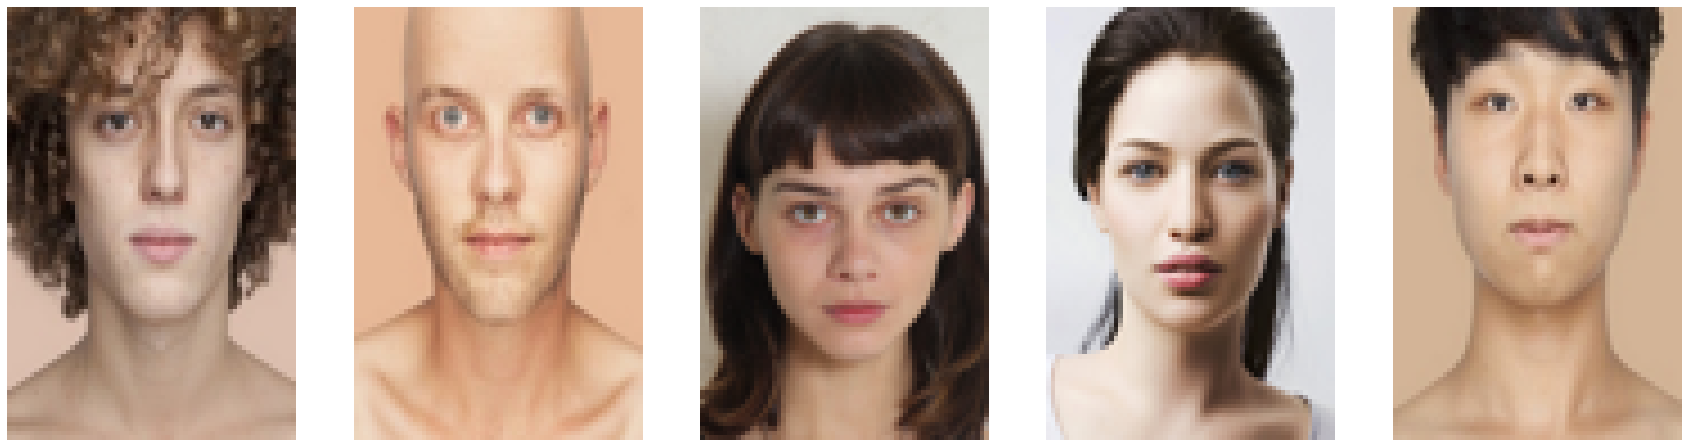

In [ ]:
# Получение списка файлов с путями
file_list = glob.glob(SOURCE_DIR+'*.*')

fx, ax = plt.subplots(1, 5, figsize = (30,10))
for i in range(5):
    # Выбор случайного изображения
    img = image.load_img(
        random.choice(file_list),
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        interpolation='bicubic')

    # Отображение изображения
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

<h3> Предобработка изображений</h3>
<p> Так как изображения загружаются долго, лучше сразу их подготовить к нужному для подачи в нейросеть виду. Тогда в процессе обучения мы не будем тратить время на их загрузку и обработку. Реалзиуем функцию  для предобработки:

In [ ]:
# Функция по предобработке изображений
def create_data():
    """ Аргументы: 
              source_dir - папка где хранятся изображения
              result_dir - папка, куда сохранять подготовленные данные
    
    """  
    # Получаем список файлов с путями
    file_list = glob.glob(SOURCE_DIR+'*.*')
    for i, file_name in enumerate(file_list):
        #==== Блок прогресса ==== # 
        print(f"\r{round((i/len(file_list))*100,1)}%...", end="", flush=True)
        
        # Загрузка изображения и преобразование в numpy
        img_arr = image.img_to_array(
            image.load_img(
                file_name,
                target_size=(IMG_HEIGHT, IMG_WIDTH)
                )
            )
        
        # Нормирование изображения
        img_arr = (img_arr - 127.5)/127.5 
        
        # Сохранение numpy-массива
        np.save(
            os.path.join(
                NUMPY_DIR,
                str(i+1)
                ),
            img_arr) # сохраняем numpy массив с изображением с порядковым номером 
    print(f'Всего в обработано: {len(file_list)} файлов')

In [ ]:
# Проверка на наличие папки и создание директории
if not(os.path.exists(NUMPY_DIR)):
    os.mkdir(NUMPY_DIR)

In [ ]:
# Подготовка numpy-масивов данных
create_data()

100.0%...Всего в обработано: 5018 файлов


In [ ]:
# Количество сохраненных numpy-данных
print(f'Количество файлов в папке: {len(os.listdir(NUMPY_DIR))}')

Количество файлов в папке: 5018


<h1><b> Вспомогательные функции </b></h1>

<h2> Отображение progressbar'a </h2>

In [ ]:
def print_log_progress(startTime, current, amount, params, epoch):
  #Мы будем выводить прогрессбар, подобный прогрессбару при обучении нейронных сетей на Keras
  #Формат прогрессбара 23/120 [=====>------------------------]
  
  bar_len = 30 #Длина бара 
  percent = int(current * bar_len / amount) #current номер текущей операции, amount общая длина цикла, params - можно передать параметры лосс и т.д
  progressbar = ''

  for i in range(bar_len): #Проходим по всем элементам прогрессбара и добавляем символы в соответсвии с прогресом 
    if(i < percent):
      progressbar += '='
    elif(i == percent):
      progressbar += '>'
    else:
      progressbar += '-'

  #Добавялем в финальное сообщение символ переноса коретки консоли на начальную строку, добавляпем информацию о номере батча
  #количестве всех батчей, прогрессбар
  #Символ переноса коретки \r добавляется для того, чтобы каждый новый батч перезаписывать вывод. Таким образом вывод не будет засоряться повторяющейся информацией
  percent = round(((current/amount)*100),2)
  time2stop = round(((time.time() - startTime)/current * amount)-((time.time() - startTime)),2)
  message = "\r" +'Эпоха: '+ str(epoch+1)+' '+ str(current-1) + '/' + str(amount) + ' [' + progressbar + ']  ' + str(percent) + '% , Времени - Осталось: ' + str(round(time2stop/60,2)) + ' мин, Прошло: ' + str(round((time.time() - startTime)/60,2))+' мин'
  #Добавляем дополнительные параметры в вывод
  for key in params:
    message += key + str(params[key]) + '. '
  
  print(message, end='')


<h2> Минибатч конвеер для реальных изображений </h2>
<p> Мы реализуем подачу данных в нейросеть Критика в виде двух функций. Для реальных изображений, создадим минибатч конвеер данных, а для генерации фейковых изображений понадобиться лишь генератор.
<p>Минибатч конвеер будет принимать на вход предварительно перемешанный список с файлами данных, текущую итерацию и размер пакета данных (batch_size). 
<p> Имея текущую итерацию мы отрезаем от списка данных кусок размером batch_size. Затем во внутреннем цикле проходим по всему теущему списку файлов и загружаем их, добавляем в список. В итоге получаем список данных размером batch_size.
<p> Далее генерируем к ним метки для Критка, как мы помним, реальным изображениям соответствует метка <b>-1</b>. 
<p> На выходе генератор возвращает массив с изображениями и массив с метками

In [ ]:
def minibatch(file_list, iteration, batch_size):  
    curr_list = file_list[iteration:iteration+batch_size] #берем текущий список файлов длиной batch_size
    list_images = [] # задаем список с изображениями
    labels = [] # список с метками
    for f in curr_list:
        img_arr = np.load(f)
        list_images.append(img_arr) # записываем очередной файл в список
    labels = -np.ones((batch_size, 1))
    return np.array(list_images), labels

Посмотрим, что выдает наш батч конвеер

In [ ]:
file_list = glob.glob(NUMPY_DIR+'*.npy')  # Получение списка файлов
iteration = 13
batch_size = 3
img_true, labels = minibatch(file_list, iteration, batch_size)
print(f'Батч с картинками {img_true.shape}')
print(f'Батч с лейблами {labels}')

Батч с картинками (3, 96, 64, 3)
Батч с лейблами [[-1.]
 [-1.]
 [-1.]]




> <b>Обратите внимание!</b> Приведенный выше подход работы с данными, не является обязательным в работе с данной задачей, так как размер БД и самих изоражений небольшой. Т.е. вы можете сразу обработать все изображения и загрузить их в один numpy массив, что не приведет к нехватке памяти.
<br>Но надо уметь применять последовательную подачу данных, если вам предстоит работать с чем-то большим. 

<h2>Функция поддельных изображений</h2>

Функция принимает на вход модель генератора, размер случайного вектора шума и размер пакета.
<p>Затем мы генерируем случайный вектор в количестве batch_size и и подаем его на вход генератору, генератор генерирует изображения, которые мы передаем на выход функции. 
<p> Далее мы генерируем метки класса, в данном случае, классу "fake" должна соотвовать метка <b>1</b>. После чего, мы так же передаем массив с метаками на выход функции.<br> Посмотрим код реализации ниже:

In [ ]:
def fake_image_generator(generator, batch_size):
  #генерируем набор случайных векторов размером batch_size для подачи на вход генератору
  noise = np.random.normal(0, 1, (batch_size, NOISE_DIM))
  fake_img = generator.predict(noise)
  #Создаем метки класса для сгенерированных изображений
  labels = np.ones((batch_size, 1))
  return fake_img, labels

Мы еще не определили функцию создания генератора, поэтому протестируем функцию `fake_image_generator()` позже

<h2> Функция Вассерштейна </h2>

In [ ]:
# Определяем функцию ошибки
def wassershtein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

Посмотрим, как работает сама функция.

Создадим рандомное изображение:

In [ ]:
random_image = np.random.uniform(-1, 1, (96, 64, 3))
print(random_image.shape)

(96, 64, 3)


Выведем на экран сгенерированное изображение и реальные, полученные на предыдущем шаге с помощью функции `minibatch()`

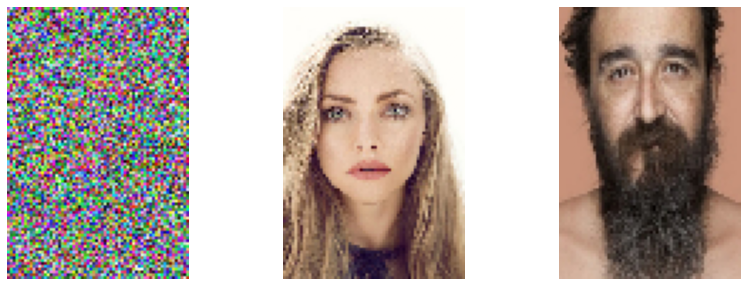

In [ ]:
fx, ax = plt.subplots(1,3, figsize = (14, 5))
ax[0].imshow(random_image * 0.5 + 0.5)
ax[0].axis('off')
ax[1].imshow(img_true[0] * 0.5 + 0.5)
ax[1].axis('off')
ax[2].imshow(img_true[1] * 0.5 + 0.5)
ax[2].axis('off')
plt.show()

Для работы вне среды Keras перед подачей изображений в функцию необходимо преобразоватьих в формат tensorflow c помощью K.constant. Далее сможем вычислить ошибку

In [ ]:
fake_loss = wassershtein_loss(K.constant(img_true[0]), K.constant(random_image))
print(fake_loss.numpy()) 

0.001116043


Теперь посчитаем ошибку для изображения в сравнении само с собой

In [ ]:
true_loss_1 = wassershtein_loss(K.constant(img_true[0]), K.constant(img_true[0]))
print(true_loss_1.numpy())

0.35798347


И ошибку в сравнении двух изображений лиц:

In [ ]:
true_loss_2 = wassershtein_loss(K.constant(img_true[0]), K.constant(img_true[1]))
print(true_loss_2.numpy())

0.015189009


Оценка максимальна для реальных изображений и тем меньше, чем хуже сгенерированное изображение. Учитывая, что стохастический градиентный спуск является алгоритмом минимизации, нам надо инвертировать значения, что бы оптимизатор изменял веса в нужную сторону. Для этого мы задаем метки классов для истинных изображений (-1), а для сгенерированных (1), далее умножая полученную оценку на метку класса (на (-1) для реального и (1) для поддельного, что означает отсутствие эффекта), мы гарантируем, что ошибка будет сводиться к минимуму. 

<h2> Класс для ограничения весов</h2>

In [ ]:
# Ограничение весов модели в заданном диапазоне
class ClipConstraint():
    # Устанавливаем значения ограничений при инициализации
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # ограничиваем ввеса по значениям clip_value
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # получаем конфигурацию
    def get_config(self):
        return {'clip_value': self.clip_value}

<h1> <b> Модели генератора и дискриминатора </h1> </b>

Возьмем модели, предложенные разработчиками архитектуры:

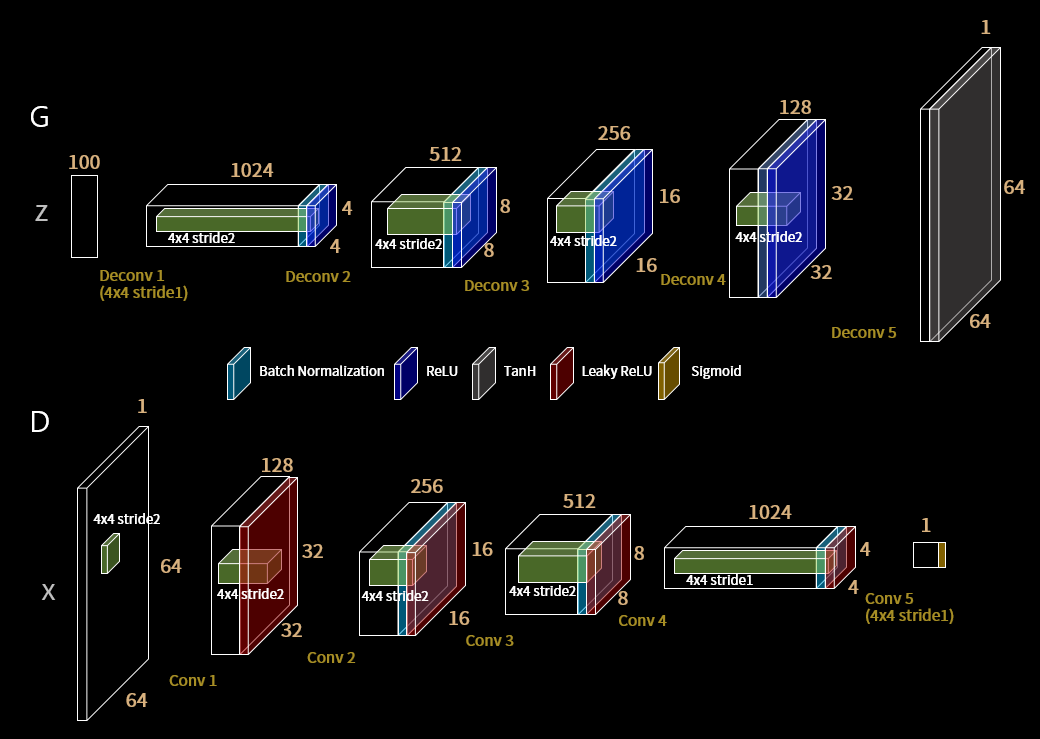

###<h2><b> Дискриминатор (критик)</b></h2>

In [ ]:
# Определяем функцию Критика
def create_critic():
  # инициализация весов
  init = RandomNormal(stddev=0.02)
  # Ограничение весов
  const = ClipConstraint(0.01)
  # компануем модель
  in_img = Input(shape=IMAGE_SHAPE)
  # Понижаем размерность до 32х32
  x = Conv2D(64,(4,4), strides=(2,2), padding='same',  kernel_initializer=init, kernel_constraint=const)(in_img)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  # Понижаем размерность до 16х16
  x = Conv2D(128,(4,4), strides=(2,2), padding='same',  kernel_initializer=init, kernel_constraint=const)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  # Понижаем размерность до 8х8
  x = Conv2D(256,(4,4), strides=(2,2), padding='same',  kernel_initializer=init, kernel_constraint=const)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)
  # Понижаем размерность до 4х4
  x = Conv2D(512,(4,4), strides=(2,2), padding='same',  kernel_initializer=init, kernel_constraint=const)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x) 
  x = Flatten()(x)
  output = Dense(1, activation='linear')(x) 
  model = Model(in_img, output, name="critic")
  model.compile(loss=wassershtein_loss, optimizer=RMSprop(learning_rate = 0.00005))
  return model

c_model= create_critic()
c_model.summary()

Model: "critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 64, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 32, 64)        3136      
                                                                 
 batch_normalization_4 (Batc  (None, 48, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 48, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 24, 16, 128)       131200    
                                                                 
 batch_normalization_5 (Batc  (None, 24, 16, 128)      512       
 hNormalization)                                            

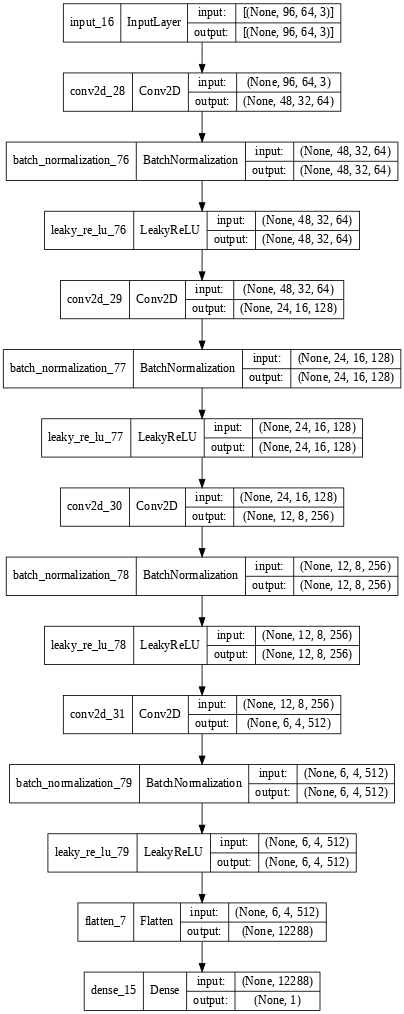

In [ ]:
plot_model(c_model, dpi=60, show_shapes=True)

<h2></b> Функция Генератора </b></h2>
<p>
Модель генератора принимает в качестве входных данных шум и выводит одно изображение

Это достигается за счет использования полносвязного слоя для интерпретации точки в скрытом пространстве и обеспечения достаточных активаций, которые могут быть преобразованы во множество копий (в данном случае 512) версии выходного изображения с низким разрешением (например, 4 × 4 ). Затем он трижды масштабируется, утраивая размер и увеличивая в девять раза площадь активаций каждый раз, используя транспонированные сверточные слои.

В модели используются лучшие практики, такие как активация LeakyReLU, размер ядра, который является фактором размера шага, и функция активации гиперболического тангенса (tanh) в выходном слое.

Функция `create_generator()` ниже определяет модель генератора, но намеренно не компилирует ее, поскольку она не обучается напрямую, а затем возвращает модель. Размер скрытого пространства параметризуется как аргумент функции.

In [ ]:
# Функция генератора
def create_generator():
   noise = Input(shape=(NOISE_DIM,))
   # инициализируем веса
   init = RandomNormal(stddev=0.02)
   # Базовое изображение 3x2
   x = Dense(3*2*1024, kernel_initializer=init, use_bias=False)(noise)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x)
   x = Reshape((3,2,1024))(x)# Преобразуем вектор в изображение
   # Увеличиваем разрешение в 2 раза --> 6х4
   x = Conv2DTranspose(1024, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x) 
   # Увеличиваем разрешение в 2 раза --> 12х4
   x = Conv2DTranspose(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x) 
   # Увеличиваем разрешение в 2 раза --> 24х8
   x = Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x) 
   # Увеличиваем разрешение в 2 раза --> 48х16
   x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x)
   # Увеличиваем разрешение в 2 раза --> 48х32
   x = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
   x = BatchNormalization()(x)
   x = LeakyReLU(alpha=0.2)(x)
   # Выходной слой
   output = Conv2DTranspose(3, (7,7), activation='tanh', padding='same', kernel_initializer=init)(x)
   model = Model(noise, output, name="generator")  
   #model.output_shape
   return model

g_model= create_generator()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_5 (Dense)             (None, 6144)              3145728   
                                                                 
 batch_normalization_8 (Batc  (None, 6144)             24576     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 6144)              0         
                                                                 
 reshape_1 (Reshape)         (None, 3, 2, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 6, 4, 1024)       9438208   
 nspose)                                                 

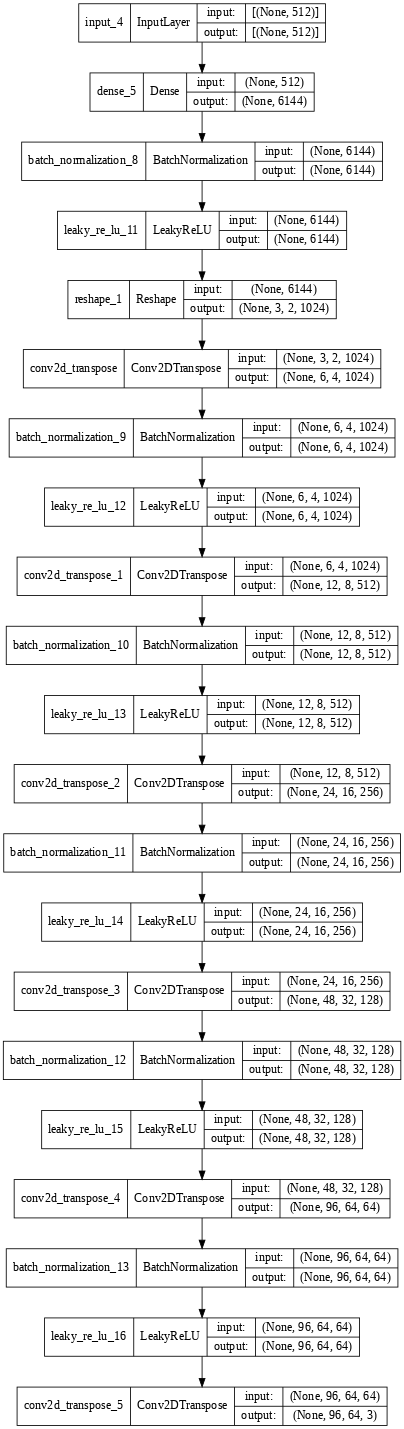

In [ ]:
plot_model(g_model, dpi=60, show_shapes=True)

<h2> <b>Комплексная модель WGAN</b></h2>

После того, как модели Критика и Генератор определены, можно определеить модель WGAN, которая их объединит в одну большую модель.

Эта большая модель - WGAN, будет использоваться для обучения весов в модели Генератора с использованием выходных данных и ошибок, рассчитанных моделью Критика. 
<p>Модель Критика обучается отдельно, и поэтому веса модели помечены как не обучаемые в этой более крупной модели GAN, чтобы гарантировать, что обновляются только веса модели генератора. "Заморозка" весов Критика, имеет эффект только при обучении комбинированной модели WGAN, а при обучении Критика в автономном режиме "заморозка" не действует.

<p>Модель WGAN принимает на вход случайный вектор (шум), использует модель Генератора для создания изображений, которые подаются в качестве входных данных в модель Критика. Критик оценивает изображения в диапазоне от -1 до 1. Далее модель обновляет веса при помощи оптимизатора RMSProp с использованием функции ошибки Вассерштейна.
 


>Интересный факт! WGAN - не является в чистом виде Generative Adversarial Network, так как в ней нет состязательности. Задача Критика не классифицировать сгенерированные изображения real/fake, а оценивать. А Генератор не пытается обмануть Критика, он пытается получить от него максимальную оценку, как хороший ученик. По сути, Генератор и Критик сотрудничают, работая вместе на одну цель.
<p> Итак определим комплсную модель WGAN

In [ ]:
# Определяем комплксную модель Генератора и Критика для обновления весов Генератора
def create_wgan(generator,critic):
  # замораживаем веса Критика
  for layer in critic.layers:
    if not isinstance(layer, BatchNormalization): # заморазиваем все слои кроме BatchNormalization
      layer.trainable = False
  model = Sequential()
  # добавляем генератор
  model.add(generator)
  # добавляем критика
  model.add(critic)
  # компилируем модель
  model.compile(loss=wassershtein_loss, optimizer=RMSprop(learning_rate=0.00005))
  return model

wgan = create_wgan(g_model,c_model)
wgan.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Functional)      (None, 96, 64, 3)         23767939  
                                                                 
 critic (Functional)         (None, 1)                 2772673   
                                                                 
Total params: 26,540,612
Trainable params: 23,753,603
Non-trainable params: 2,787,009
_________________________________________________________________


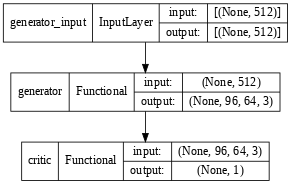

In [ ]:
plot_model(wgan, dpi=60, show_shapes=True)

Проверим, как работает наш генератор и функция `fake_image_generator()`

In [ ]:
half_batch = 3
fake_img, f_labels = fake_image_generator(g_model, half_batch)
print(f'Размер сгенерированных картинок: {fake_img.shape}')
print(f'Набор f_labels: {f_labels}')

Размер сгенерированных картинок: (3, 96, 64, 3)
Набор f_labels: [[1.]
 [1.]
 [1.]]


Посмотрим на результат генерации:

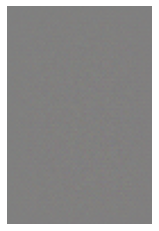

In [ ]:
plt.imshow(fake_img[0]* 0.5 + 0.5)
plt.axis('off')
plt.show()

<h3>Функция для вывода изображений</h3>

Чтобы оценивать наш WGAN в процессе обучения, самый лучший способ, это выводить сгенерированные генератором изображения на экран и субъективно оценивать их. Напишем вспомогательную функцию, которая будет это делать.

In [ ]:
def show_performance_wgan(model, n_img_show):
  '''Аргументы:
              model - модель генератора,
              n_img_show - количество выводимых картинок,
  '''
  
  noise = np.random.normal(0, 1, (n_img_show, NOISE_DIM))
  img = model.predict(noise)
  
  plt.figure(figsize=(15,9))  
  for i in range(n_img_show): # проходимся по всем картинкам
     # Сгенерированное изображение
     ax=plt.subplot(1, n_img_show, i+1)
     plt.imshow(img[i]* 0.5 + 0.5)
     ax.get_xaxis().set_visible(False)
     ax.get_yaxis().set_visible(False)
     
  plt.show()      

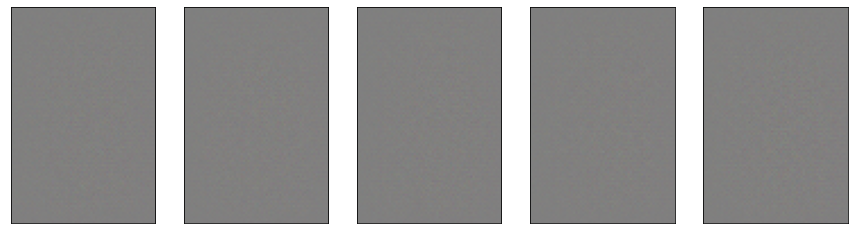

In [ ]:
show_performance_wgan(g_model,5)

Помимо качества изображения, рекомеднуется отслеживать значения loss функций и accuracy моделей в процессе обучения.
<p>Loss функцию Критика для реальных и сгенерированных изображений, а так же loss Генератора, можно отслеживать для каждого обновления. Затем их можно использовать для построения графиков в конце цикла обучения.
<p>Функция представленная ниже реализует это и сохраняет результат в файл.

<h3>Функцияя графиков loss</h3>

In [ ]:
# Функция вывода графиков
def plot_log_of_loss(d1_loss_list, d2_loss_list, g_loss_list, d_acc_list):
  # Строим графики Loss моделей
   plt.plot(d1_loss_list, label="Критик Real_img")
   plt.plot(d2_loss_list, label="Критик Fake_img")
   plt.plot(g_loss_list, label="Ошибка генератора")
   plt.legend()
   plt.savefig('plot_loss.png')
   plt.show()
   plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
   plt.legend()
   plt.show()

<h1><b>Тренировочный алгоритм</b></h1>

Теперь мы готовы приступить к написанию алгоритма обучения
<p> Сначала обучаем модель Критика. Критик обучается на половине батча реальных изображений и половине батча сгенерированных Генератором (поддельных), вместе формируя один пакет обновлений веса. Затем это повторяется 5 раз (n_critic=5), как требует алгоритм WGAN

<p> Затем Генератор обновляется с попощью составной модели WGAN. Важно напомнить, что целевую метку для сгенерированных изображений, устанавливаем -1 (Real) Это приводит к обновлениям генератора, чтобы он генерировал изображения больше похожие на реальные.

<p>Тренировочный алгоритм приведенный ниже реализует это. На вход мы подаем модели генератора, критика и комбинированную модель WGAN; набор данных (в нашем случае в виде генератора), размер бызы данных, задаем количество эпох для обучения и размер пакета данных (batch_size)

<p>Каждый цикл сохраняем модели Генератора и Критика

<p>Прогресс обучения отслеживаем, выводя сгенерированние изображения, а так же графики функций ошибок с заданной переодичностью
<p>Итак напишем тренировочную функцию:

In [ ]:
#Тренировочная функция
def train(generator, critic, wgan, n_critic, num_epochs):
    ''' Аргументы:
        generator - принимает модель генератора
        critic - прнимает модель критика
        wgan - принимает комплексную модель wgan
        n_critic - количество итерация для обучения критика
        num_epochs - количество тренировочных эпох

    '''

    # Получаем список файлов с путями
    file_list = glob.glob(NUMPY_DIR+'*.npy')
    
    # фиксируем длину набора данных
    dataset_len = len(file_list) 

    # интервал через который будем смотреть что получается
    view_interval = 10 
  
    # Задаем списки для сохранения истории изменения значений ошибкок
    c1_loss_log, c2_loss_log, g_loss_log, c_acc_log = list(), list(), list(), list()
  
    # Задаем размер полубатча
    half_batch = BATCH_SIZE//2

    startTime = time.time() # засекаем время начала обучения
    n = 1
    collaps = 0
    for epoch in range(num_epochs): 
        shuffle(file_list) # перемешиваем список с именами файлов на каждой эпохе
        step = 0 #шаг по датасету
        print('') # переносим вывод прогрессбара на новую строку
        for i in range(0, dataset_len, BATCH_SIZE):
            # Блок обучения Критика=====================================
            c1_loss_tmp, c2_loss_tmp, c_acc_tmp = list(), list(), list() # создаем пустые списки для кранения текущих значений ошибки
            startTime_critic = time.time() # засекаем время начала обучения Критика
            d = 0
            for j in range(n_critic):
                step= (step+half_batch) % dataset_len # делаем шаг по базе данных, когда достигут конец датасета шаг сбрасывается на 0
                if step + half_batch > dataset_len:
                    step = 0
                # Обучаем Критика на реальных изображениях и обновляем его веса
                real_img, real_label = minibatch(file_list, step, half_batch) # Получаем реальные картинки и лейблы из конвеера
                c1_loss_real = critic.train_on_batch(real_img, real_label)
             
                # Обучаем Критика на поддельних изображениях
                fake_img, f_labels = fake_image_generator(generator, half_batch)
                c2_loss_fake = critic.train_on_batch(fake_img, f_labels)
             
                # Вычисляем качство критика
                c_loss = 0.5* np.add(c1_loss_real, c2_loss_fake) # получаем ошибку критика                
                # Записываем значения ф-ции ошибки в лог 
                c1_loss_tmp.append(c1_loss_real)
                c2_loss_tmp.append(c2_loss_fake)
                c_acc_tmp.append(c_loss)                

            # Записываем ошибки моделей в лог листы
            c1_loss_log.append(np.mean(c1_loss_tmp))
            c2_loss_log.append(np.mean(c2_loss_tmp))
            c_acc_log.append(np.mean(c_acc_tmp))

            # Блок обучения Генератора==================================
            noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM)) # генерируем набор шумов для подачи в генератор
            labels_gan = -np.ones((BATCH_SIZE, 1)) # генерируем метки класса для генератора -1 (реальные изображения)
         
            # Обучаем генератор
            g_loss = wgan.train_on_batch(noise, labels_gan)
            # Записываем ошибку генератора в лог 
            g_loss_log.append(g_loss) 
    
            #Задаем параметры, которые будем выводить 
            params = {' Critic_real_loss: ': round(c1_loss_log[-1], 2), 
                    'Critic_fake_loss: ': round(c2_loss_log[-1], 2), 
                    'Critic_accur: ': round(c_acc_log[-1], 2),
                    'Gen_loss: ': round(g_loss_log[-1], 2)}

            set_len = (dataset_len//BATCH_SIZE)*BATCH_SIZE # если длина датасета не кратна батчу, подравниваем ее для правильного вывода прогресса
            print_log_progress(startTime, i+1, set_len, params, epoch)
 
            
        # Показываем текущую трансформацию
        if view_interval // n == 1:
            print('') # переносим вывод на новую строку             
            show_performance_wgan(generator,5) # покахываем сгенерированные изображения
            plot_log_of_loss(c1_loss_log, c2_loss_log, g_loss_log, c_acc_log)
            n=1 # сбрасываем счетчик
        n+=1
    # Выдаем предупреждающий сигнал. Не работает в Colab           
    return  c1_loss_log, c2_loss_log, c_acc_log, g_loss_log


Эпоха: 1 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 0.55 мин Critic_real_loss: -102.04. Critic_fake_loss: -96.28. Critic_accur: -99.16. Gen_loss: 93.57. 
Эпоха: 2 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 1.05 мин Critic_real_loss: -158.98. Critic_fake_loss: -159.37. Critic_accur: -159.18. Gen_loss: 43.33. 
Эпоха: 3 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 1.55 мин Critic_real_loss: -216.6. Critic_fake_loss: -226.84. Critic_accur: -221.72. Gen_loss: -201.02. 
Эпоха: 4 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 2.05 мин Critic_real_loss: -264.12. Critic_fake_loss: -265.42. Critic_accur: -264.77. Gen_loss: -270.87. 
Эпоха: 5 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 2.55 мин Critic_real_loss: -343.29. Critic_fake_loss: -355.8. Critic_accur: -

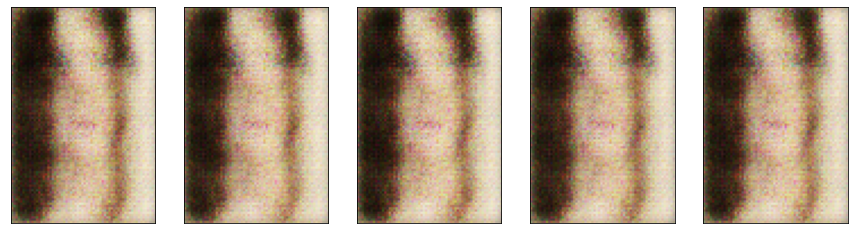

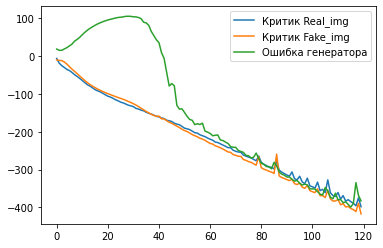

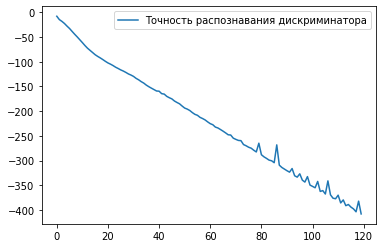


Эпоха: 7 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 3.57 мин Critic_real_loss: -441.27. Critic_fake_loss: -457.22. Critic_accur: -449.25. Gen_loss: 328.95. 
Эпоха: 8 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 4.07 мин Critic_real_loss: -534.54. Critic_fake_loss: -549.68. Critic_accur: -542.11. Gen_loss: 443.68. 
Эпоха: 9 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 4.57 мин Critic_real_loss: -608.64. Critic_fake_loss: -618.86. Critic_accur: -613.75. Gen_loss: 526.12. 
Эпоха: 10 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 5.08 мин Critic_real_loss: -689.1. Critic_fake_loss: -695.55. Critic_accur: -692.32. Gen_loss: 676.87. 
Эпоха: 11 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 5.58 мин Critic_real_loss: -763.63. Critic_fake_loss: -764.4. Critic_accu

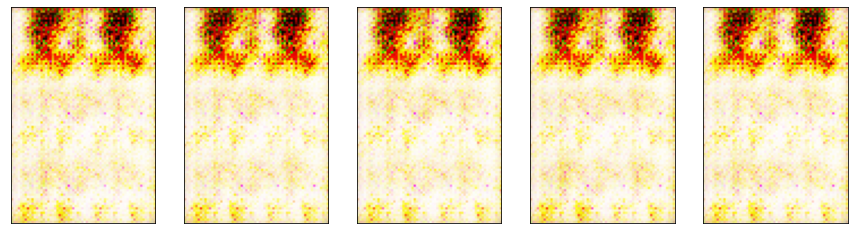

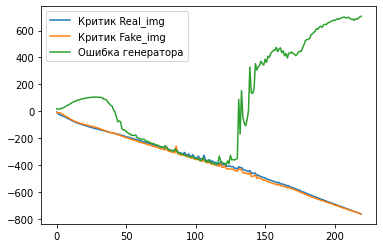

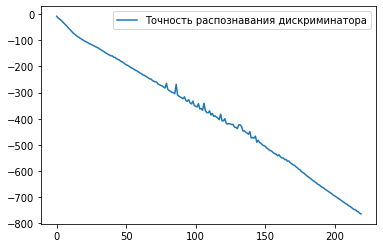


Эпоха: 12 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 6.1 мин Critic_real_loss: -840.14. Critic_fake_loss: -827.14. Critic_accur: -833.64. Gen_loss: 804.5. 
Эпоха: 13 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 6.61 мин Critic_real_loss: -917.52. Critic_fake_loss: -880.91. Critic_accur: -899.21. Gen_loss: 857.79. 
Эпоха: 14 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 7.12 мин Critic_real_loss: -998.09. Critic_fake_loss: -946.04. Critic_accur: -972.06. Gen_loss: 917.78. 
Эпоха: 15 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 7.62 мин Critic_real_loss: -1079.38. Critic_fake_loss: -1013.46. Critic_accur: -1046.42. Gen_loss: 1009.93. 
Эпоха: 16 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 8.13 мин Critic_real_loss: -1162.2. Critic_fake_loss: -1090.52. Cri

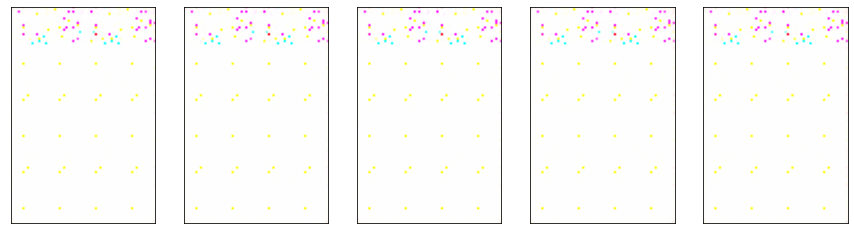

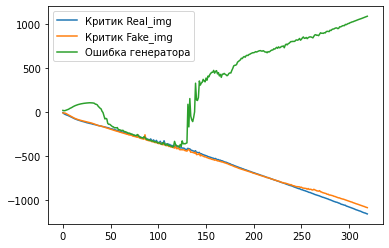

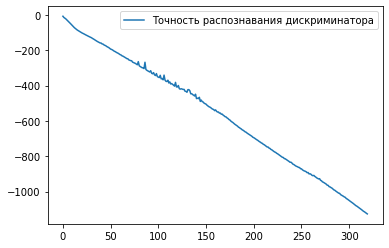


Эпоха: 17 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 8.65 мин Critic_real_loss: -1249.4. Critic_fake_loss: -1169.53. Critic_accur: -1209.46. Gen_loss: 1171.21. 
Эпоха: 18 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 9.16 мин Critic_real_loss: -1336.8. Critic_fake_loss: -1249.69. Critic_accur: -1293.24. Gen_loss: 1252.31. 
Эпоха: 19 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 9.66 мин Critic_real_loss: -1422.23. Critic_fake_loss: -1332.06. Critic_accur: -1377.14. Gen_loss: 1334.36. 
Эпоха: 20 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 10.17 мин Critic_real_loss: -1512.91. Critic_fake_loss: -1373.29. Critic_accur: -1443.1. Gen_loss: 1375.58. 
Эпоха: 21 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 10.67 мин Critic_real_loss: -1603.94. Critic_fake_loss:

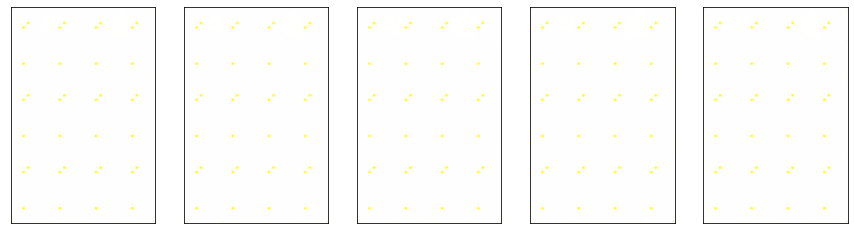

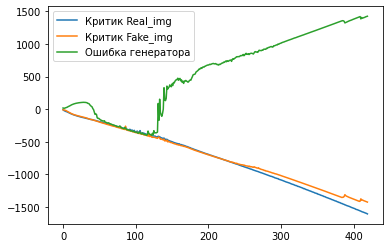

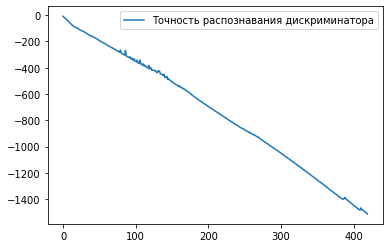


Эпоха: 22 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 11.18 мин Critic_real_loss: -1694.08. Critic_fake_loss: -1506.12. Critic_accur: -1600.1. Gen_loss: 1508.22. 
Эпоха: 23 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 11.68 мин Critic_real_loss: -1788.41. Critic_fake_loss: -1590.59. Critic_accur: -1689.5. Gen_loss: 1592.87. 
Эпоха: 24 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 12.19 мин Critic_real_loss: -1882.48. Critic_fake_loss: -1676.12. Critic_accur: -1779.3. Gen_loss: 1678.73. 
Эпоха: 25 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 12.69 мин Critic_real_loss: -1980.94. Critic_fake_loss: -1763.61. Critic_accur: -1872.28. Gen_loss: 1765.72. 
Эпоха: 26 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 13.19 мин Critic_real_loss: -2075.02. Critic_fake_lo

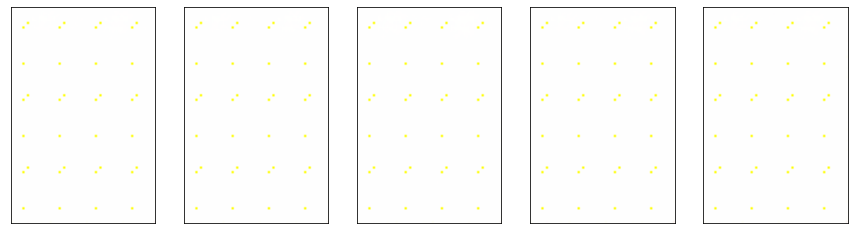

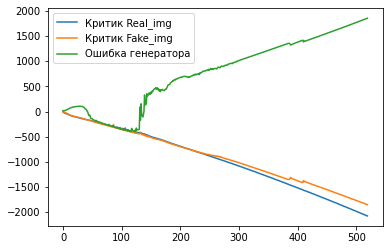

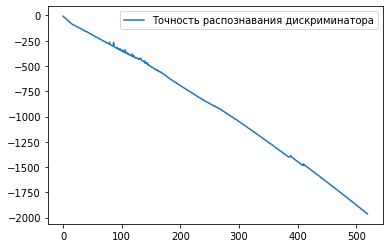


Эпоха: 27 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 13.71 мин Critic_real_loss: -2177.76. Critic_fake_loss: -1942.15. Critic_accur: -2059.95. Gen_loss: 1944.7. 
Эпоха: 28 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 14.22 мин Critic_real_loss: -2276.04. Critic_fake_loss: -2033.31. Critic_accur: -2154.68. Gen_loss: 2036.05. 
Эпоха: 29 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 14.73 мин Critic_real_loss: -2379.22. Critic_fake_loss: -2126.21. Critic_accur: -2252.71. Gen_loss: 2129.0. 
Эпоха: 30 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 15.23 мин Critic_real_loss: -2485.39. Critic_fake_loss: -2220.52. Critic_accur: -2352.96. Gen_loss: 2223.21. 
Эпоха: 31 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 15.74 мин Critic_real_loss: -2590.35. Critic_fake_l

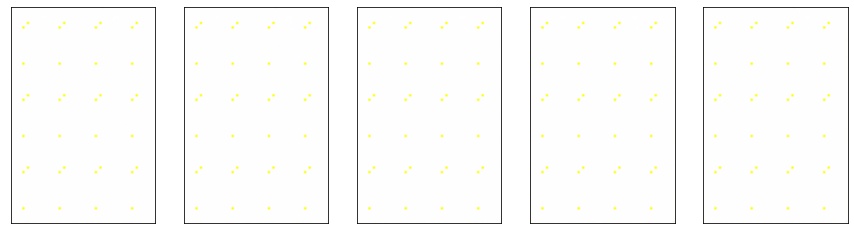

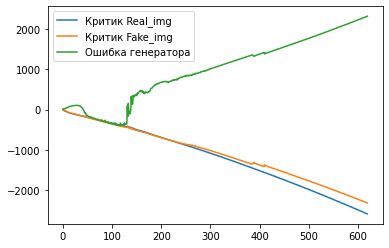

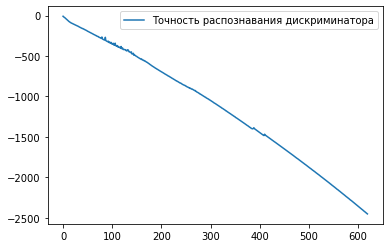


Эпоха: 32 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 16.26 мин Critic_real_loss: -2698.63. Critic_fake_loss: -2413.35. Critic_accur: -2555.99. Gen_loss: 2416.16. 
Эпоха: 33 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 16.77 мин Critic_real_loss: -2807.49. Critic_fake_loss: -2512.26. Critic_accur: -2659.87. Gen_loss: 2514.99. 
Эпоха: 34 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 17.29 мин Critic_real_loss: -2917.54. Critic_fake_loss: -2612.09. Critic_accur: -2764.82. Gen_loss: 2614.83. 
Эпоха: 35 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 17.79 мин Critic_real_loss: -3028.13. Critic_fake_loss: -2713.69. Critic_accur: -2870.91. Gen_loss: 2716.48. 
Эпоха: 36 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 18.29 мин Critic_real_loss: -3142.67. Critic_fake

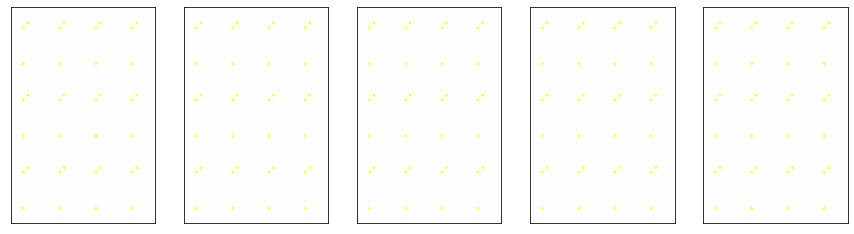

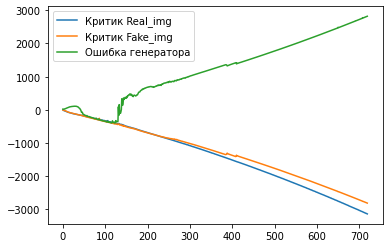

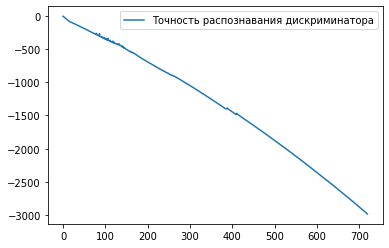


Эпоха: 37 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 18.81 мин Critic_real_loss: -3257.87. Critic_fake_loss: -2920.86. Critic_accur: -3089.36. Gen_loss: 2923.87. 
Эпоха: 38 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 19.32 мин Critic_real_loss: -3372.11. Critic_fake_loss: -3026.5. Critic_accur: -3199.3. Gen_loss: 3029.63. 
Эпоха: 39 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 19.83 мин Critic_real_loss: -3492.49. Critic_fake_loss: -3133.38. Critic_accur: -3312.93. Gen_loss: 3136.51. 
Эпоха: 40 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 20.33 мин Critic_real_loss: -3615.73. Critic_fake_loss: -3241.95. Critic_accur: -3428.84. Gen_loss: 3245.32. 
Эпоха: 41 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 20.83 мин Critic_real_loss: -3738.22. Critic_fake_l

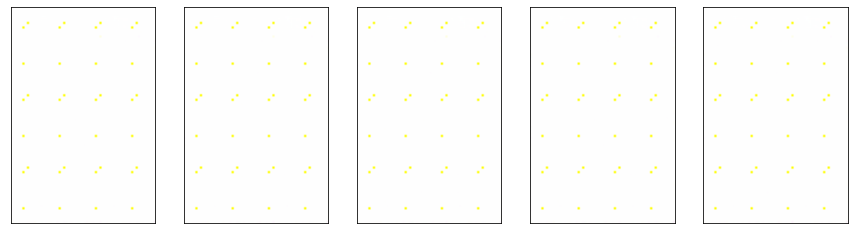

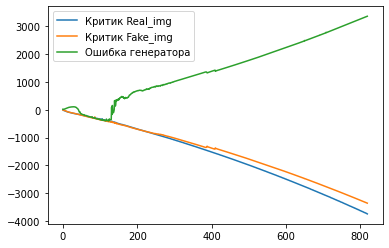

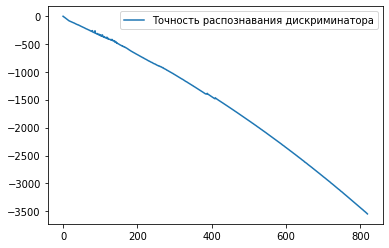


Эпоха: 42 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 21.35 мин Critic_real_loss: -3857.78. Critic_fake_loss: -3463.88. Critic_accur: -3660.83. Gen_loss: 3466.67. 
Эпоха: 43 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 21.85 мин Critic_real_loss: -3981.62. Critic_fake_loss: -3576.58. Critic_accur: -3779.1. Gen_loss: 3579.87. 
Эпоха: 44 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 22.35 мин Critic_real_loss: -4109.43. Critic_fake_loss: -3690.69. Critic_accur: -3900.06. Gen_loss: 3693.82. 
Эпоха: 45 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 22.86 мин Critic_real_loss: -4235.6. Critic_fake_loss: -3806.3. Critic_accur: -4020.95. Gen_loss: 3809.59. 
Эпоха: 46 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 23.36 мин Critic_real_loss: -4367.47. Critic_fake_lo

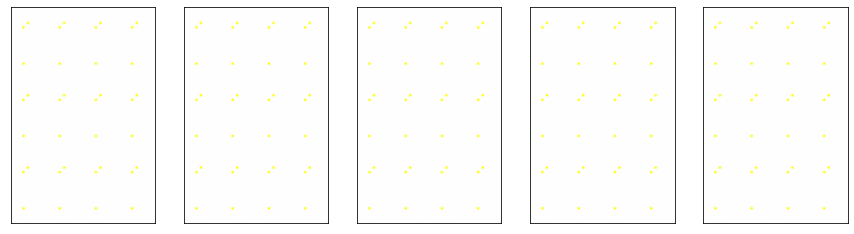

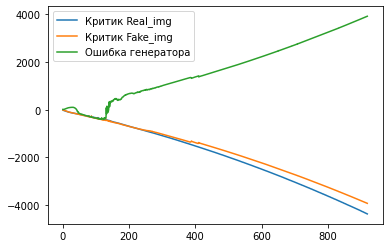

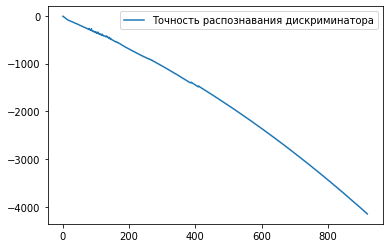


Эпоха: 47 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 23.88 мин Critic_real_loss: -4494.88. Critic_fake_loss: -4041.9. Critic_accur: -4268.39. Gen_loss: 4045.01. 
Эпоха: 48 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.01 мин, Прошло: 24.38 мин Critic_real_loss: -4629.16. Critic_fake_loss: -4161.67. Critic_accur: -4395.41. Gen_loss: 4165.19. 
Эпоха: 49 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.01 мин, Прошло: 24.89 мин Critic_real_loss: -4761.4. Critic_fake_loss: -4282.95. Critic_accur: -4522.18. Gen_loss: 4286.6. 
Эпоха: 50 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.01 мин, Прошло: 25.38 мин Critic_real_loss: -4896.7. Critic_fake_loss: -4405.85. Critic_accur: -4651.28. Gen_loss: 4409.38. 

In [ ]:
c_model= create_critic()
g_model= create_generator()
wgan = create_wgan(g_model,c_model)

result = train(
    g_model,
    c_model, 
    wgan, 
    5, 
    50)

Полученный результат показывает, что нам не удалось добиться сходимости дискриминатора и генератора. Попробуем изменить количество шагов обучения критика (n_critics)


Эпоха: 1 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 0.94 мин Critic_real_loss: -163.77. Critic_fake_loss: -166.23. Critic_accur: -165.0. Gen_loss: 154.55. 
Эпоха: 2 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 1.82 мин Critic_real_loss: -282.48. Critic_fake_loss: -292.45. Critic_accur: -287.46. Gen_loss: -203.16. 
Эпоха: 3 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 2.72 мин Critic_real_loss: -412.35. Critic_fake_loss: -424.92. Critic_accur: -418.63. Gen_loss: -398.11. 
Эпоха: 4 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 3.6 мин Critic_real_loss: -550.45. Critic_fake_loss: -562.61. Critic_accur: -556.53. Gen_loss: -544.97. 
Эпоха: 5 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 4.49 мин Critic_real_loss: -698.25. Critic_fake_loss: -708.93. Critic_acc

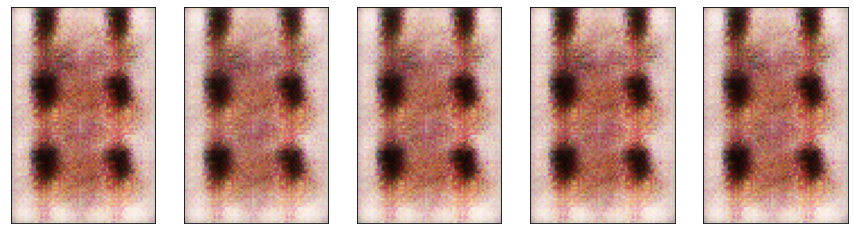

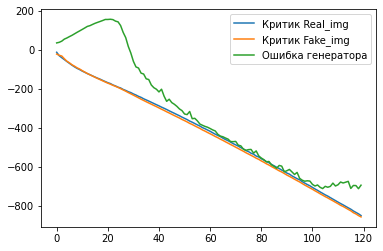

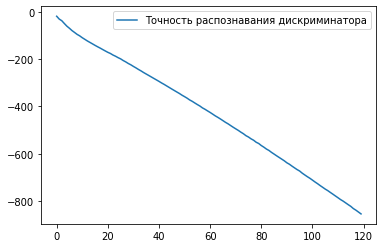


Эпоха: 7 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 6.28 мин Critic_real_loss: -1013.23. Critic_fake_loss: -1018.97. Critic_accur: -1016.1. Gen_loss: 753.67. 
Эпоха: 8 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 7.17 мин Critic_real_loss: -1184.29. Critic_fake_loss: -1185.6. Critic_accur: -1184.95. Gen_loss: -1008.53. 
Эпоха: 9 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 8.05 мин Critic_real_loss: -1362.84. Critic_fake_loss: -1358.67. Critic_accur: -1360.75. Gen_loss: -1263.97. 
Эпоха: 10 4864/4864 [==============================]  100.02% , Времени - Осталось: -0.0 мин, Прошло: 8.94 мин Critic_real_loss: -1546.65. Critic_fake_loss: -1541.52. Critic_accur: -1544.09. Gen_loss: -1516.48. 

In [ ]:
c_model= create_critic()
g_model= create_generator()
wgan = create_wgan(g_model,c_model)

result = train(
    g_model,
    c_model, 
    wgan, 
    10, 
    10)

<h3> <b>Выявленные проблемы алгоритма WGAN </b></h3>
<p>WGAN также же, как и GAN требует определенной настройки. Если в GAN требуется подобрать модели Генератора и Дискриминатора таким образом, что бы они находились в балансе, то WGAN требует подбора количества итераций Критика, а так же подобра его архитектуры. WGAN, не решает основных проблем GAN, а является лишь пробным шаром, в большом ряде исследований в целом направления GAN. В частности на графике ниже видно, что добитьсяч сходимости, также сложно, как и при разработке GAN. Единственный плюс в том, что графики наглядно отражают поведение Критика и Генератора

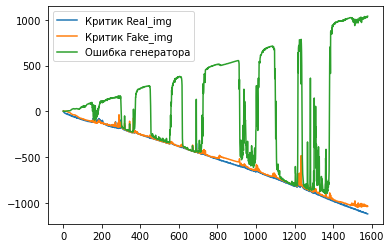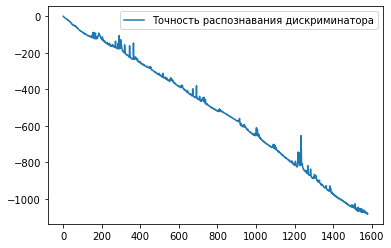

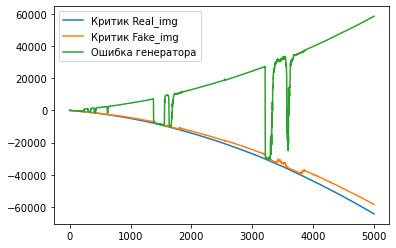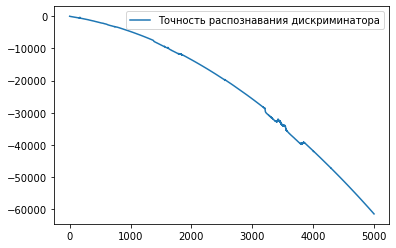

<h1> <b> Продвинутый вариант WGAN GP (Gradient penalty) </b> </h1>
<font size='4'>Вассерштейн GAN c градиентным штрафом</font>

Оригинальный Вассерштейн GAN использует расстояние Вассерштейна для создания оценочной функции, которая имеет лучшие теоретические свойства, чем функция в исходном алгоритме GAN. 
 
Авторы WGAN предложили идею ограничения весов модели для достижения поставленных целей и хотя ограничение веса работает, это довольно проблематичный способ, так как может вызвать нежелательное поведение. Например, очень глубокий дискриминатор (критик) WGAN часто не может сойтись. (пример в коде выше с генерацией лиц)
 <p> <b>WGAN-GP</b> Вместо того, что бы ограничивать веса, авторы предлагают <b>"градиентный штраф"</b>, чтобы обеспечить соблюдение ограничения Липшица. Что, в свою очередь, обеспечивает плавное обучение. 

<h2> <b> Fashion MNIST </b> </h2>

In [ ]:
IMG_SHAPE = (28, 28, 1)
channel = 1 # Количество каналов (используется при интерполяции изображения)
BATCH_SIZE = 512

# Задаем размер случайного вектора
noise_dim = 128

# Загружаем базу данных
fashion_mnist = datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Число примеров: {len(train_images)}")
print(f"Размер изображений в нмборе данных: {train_images.shape[1:]}")

# Добавляем размерность каждому изображению (28, 28, 1) и нормализуем его в диапазоне [-1, 1]
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

4431872/4422102 [==============================] - 0s 0us/step
Число примеров: 60000
Размер изображений в нмборе данных: (28, 28)


## Критик для Mnist

Набор данных Mnist имеет размер изображений 28х28 пикселей. Так как мы будем применять шаг свертки, у нас может получится странная размерность при делении нечетных чисел. Например: 

$(28, 28) -> Conv(s2) -> (14, 14) -> Conv(s2) -> (7, 7) -> Conv(s2) ->(3, 3)$

 При попытке провести обратное преобразование (в генераторной части, в итоге мы не получим тот же размер, что был в начале.
<p>Что бы этого избежать мы применим простой трюк:
<font size = '3'><li> В Критике добавим слой ZeroPadding2D, чтобы изменить рамзер каждого входящего изображения с 

$(28, 28) _{zeropad} -> (32, 32)$

<li>В Генераторе мы применим обрезку финального изображения при помощи слоя Cropping2D, что бы оно соответстовало, реальным изображениям базы данных.

Напишем сверточный блок, который будет содержать в себе сразу и пакетную нормализацию и дропаут, мы будем применять его в наших моделях

In [ ]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 32, 32, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                     

## Генератор для Mnist
<p> Генератор так же будет состоять из вспомогательных блоков, т.е. мы напишем функцию объединяющую несоклько слоев в один блок.

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x, 1, Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    x = Cropping2D((2, 2))(x)

    g_model = Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_8 (Dense)             (None, 4096)              524288    
                                                                 
 batch_normalization_18 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_6 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                     

Итак у нас определены модели Критика и Генератор, теперь можно реализовать модель WGAN-GP

## Создаем модель WGAN-GP

In [ ]:
# Алгоритм WGAN-GP
class WGAN(Model):
    def __init__( self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0,):
        """
        Аргументы:
                    discriminator - модель дискриминатора или Критика
                    generator - модель генератора
                    latent_dim - размер скрытого пространства (вектора с шумом)
                    critic_extra_step=3 - количество добавочных шагов для критика
                    gp_weight = 10.0 - весовой коэффициент на него умножаем штраф
        """      
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
    
    # Функция компиляции моделей  
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    
    # Функция рассчета Градиентного штрафа
    def gradient_penalty(self, batch_size, real_images, fake_images):
        ''' Рассчитываем Градиентный штраф
            Эта ошибка рассчитывается на интерполированном изображении
            и добавляется к ошибке дискриминатора.
        '''
        # Получаем интерполированное изображение
        alpha = tf.random.normal([batch_size, 1, 1, channel], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        # То же самое, что: interpolated = alpha * fake_images  + (1 - alpha) * real_images

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Получаем оценку Дискриминатора для интерполированного изображения
            pred = self.discriminator(interpolated, training=True)

            # 2. Рассчитываем градиенты относительно интерполированного изображения
            grads = gp_tape.gradient(pred, [interpolated])[0]
            # 3. Рассчитвываем нормировку градиента
            norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    # Тренировочная функция
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Задаем внутренний размер пакета
        batch_size = tf.shape(real_images)[0]

        # Для каждого батча мы выполняем следующие шаги
        # как указано в оригинальном документе:
        # 1. Тренируем Генератор и получаем его ошибку g_loss
        # 2. Тренируем Дискриминатор и получаем его ошибку d_loss
        # 3. Рассчитываем Градиентный штраф
        # 4. Умножаем Градиентный штраф на постоянный весовой коэффициент
        # 5. Добавляем рассчитанный выше штраф к ошибке Дискриминатора d_loss
        # 6. Возвращаем ошибки Генератора и Дискриминатора как словарь

        # Вначале тренеруем Дискриминатор. В оригинальной статье рекомендуется тренировать Дискриминатор (Критика)
        # в `x` раз больше (обычно 5) по сравнению с Генератором
        # Мы попробуем тренировать 3 раза Дискриминатор, на один раз Генератора сокращая время тренировки

        for i in range(self.d_steps):
            # Получаем вектор шума
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Генерируем поддельные изображения из вектора шума
                fake_images = self.generator(random_latent_vectors, training=True)
                # Получаем оценку Дискриминатора за поддельное изображение
                fake_logits = self.discriminator(fake_images, training=True)
                # Получаем оценку Дискриминатора за рельное изображение
                real_logits = self.discriminator(real_images, training=True)

                # Вычисляем оценку Дискриминатора используя две предыдущие оценки
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Рассчитываем градиентный штраф
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Добавляем градиентный штраф к оригинальной ошибке Дискриминатора
                d_loss = d_cost + gp * self.gp_weight

            # Получаем градиент согласно ошибке Дискриминатора c_loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Обновляем веса Дискриминатора используя его оптимизатор
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Блок тренировки генератора
        # Получаем случайный вектор
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Генерируем поддельные изображения используя генератор
            generated_images = self.generator(random_latent_vectors, training=True)
           # Получаем оценку Дискриминатора
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Рассчитываем ошибку Генератора
            g_loss = self.g_loss_fn(gen_img_logits)

        # Рассчитываем градиент согласно ошибке Генератора (обратное распространение ошибки)
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Обновляем веса генератора используя его оптимизатор
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

## Самописный CallBack

In [ ]:
class GANMonitor(callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = preprocessing.image.array_to_img(img)
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

## Тренировочный Блок Mnist

In [ ]:
# Создаем оптимизаторы для обоих сетей
# Используем рекомендованные параметры (learning_rate=0.0002, beta_1=0.5)
generator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Определяем функцию ошибки для Дискриминатора, она должна быть (fake_loss - real_loss)
# Градиентный штраф сюда мы добавим позже
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Определяем функцию ошибки генератора
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

epochs = 20

# Создаем наш колбэк `GANMonitor` при помощи Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Создаем модель WGAN
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3
)

# Компилируем модели входящие в состав WGAN
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Начинаем тренировку модели
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/20
118/118 [==============================] - 73s 581ms/step - d_loss: -7.2588 - g_loss: -6.9276
Epoch 2/20
118/118 [==============================] - 69s 581ms/step - d_loss: -6.5116 - g_loss: -0.0591
Epoch 3/20
118/118 [==============================] - 69s 581ms/step - d_loss: -5.8908 - g_loss: 5.8935
Epoch 4/20
118/118 [==============================] - 69s 581ms/step - d_loss: -5.3701 - g_loss: 9.4011
Epoch 5/20
118/118 [==============================] - 69s 581ms/step - d_loss: -4.9021 - g_loss: 10.4087
Epoch 6/20
118/118 [==============================] - 69s 581ms/step - d_loss: -4.5953 - g_loss: 9.6893
Epoch 7/20
118/118 [==============================] - 69s 581ms/step - d_loss: -4.3630 - g_loss: 10.2621
Epoch 8/20
118/118 [==============================] - 69s 581ms/step - d_loss: -4.1014 - g_loss: 10.2367
Epoch 9/20
118/118 [==============================] - 69s 581ms/step - d_loss: -3.9049 - g_loss: 10.0806
Epoch 10/20
118/118 [==============================] - 69s

Функция для просмотра изображений

In [ ]:
def wgan_show(model, n_img_show, noise_dim):
      noise = tf.random.normal(shape=(n_img_show, noise_dim))
      img = model(noise)
      plt.figure(figsize=(20,10))
      n=0
      for m in range (n_img_show): # проходимся по всем картинкам
         # Сгенерированное изображение
         ax=plt.subplot(1,n_img_show,m+1)
         plt.imshow(img[m,:,:,0]* 0.5 + 0.5,cmap='gray')
         ax.get_xaxis().set_visible(False)
         ax.get_yaxis().set_visible(False)
      plt.show()

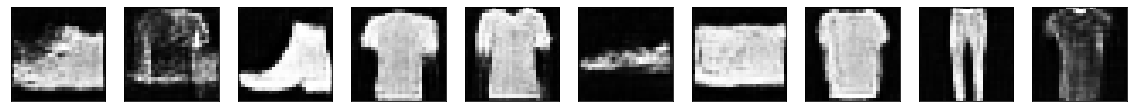

In [ ]:
wgan_show(g_model, 10, 128)

**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1WvOchAf_I2vEyRC9u9WCPYJvl78g1uVw?usp=sharing)
2. Практический ноутбук